In [1]:
#!/usr/local/bin/python3.7

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy_indexed as npi
import os, glob

os.chdir('/Users/hausfath/Desktop/Climate Science/Carbon Brief/Carbon Cycle Feedbacks/')

/usr/local/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [11]:
#Method to merge C4MIP model runs into a single file with the desired variable.

def merge_models(folder, variable = 'temp'):
    all_files = glob.glob(folder + "/*.txt")
    li = []
    
    for filename in all_files:
        df = pd.read_csv(filename, index_col=0, header=None, delim_whitespace=True)
        if df.shape[1] > 1:
            model_name = filename.partition("_Amon_")[2].partition("_esmrcp85")[0]
            df.columns = ['co2', 'temp', 'land', 'ocean']
            df = df[[variable]]
        else:
            model_name = filename.partition("tas_Amon_")[2].partition("_rcp85")[0]
        df.columns = [model_name]
        li.append(df)
    
    frame = pd.concat(li, axis=1, join='outer')
    return frame

#Import datafiles 

folder = 'co2tasnbpfgco2_emissiondriven' #'tas_concdriven'
c4mip = merge_models(folder, variable = 'co2')
rcp85_full = pd.read_excel('RCP85 concentrations.xlsx')
rcp26_full = pd.read_excel('RCP26 concentrations.xlsx')
a1b_full = pd.read_excel('A1B concentrations.xlsx')

rcp85 = rcp85_full['co2_ppm'].fillna(0)
rcp26 = rcp26_full['co2_ppm'].fillna(0)
a1b = a1b_full['co2_ppm'].fillna(0)

#Dict of 2100 RCP concentrations

rcp_concs = {'rcp85': 935.874,
             'rcp60': 669.723,
             'rcp45': 538.358,
             'rcp26': 420.895}


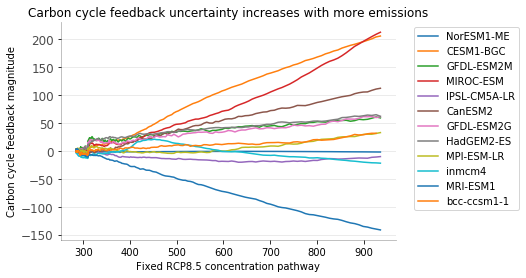

In [12]:
#Plot C4MIP results vs RCP8.5 fixed concentrations

def plot_c4mip_vs_conc(c4mip, rcp85):
    cc_val = c4mip.copy().reset_index()
    for var in list(c4mip.columns):
        cc_val[var] = cc_val[var] - rcp85
        plt.plot(rcp85, cc_val[var])
    
    plt.ylabel('Carbon cycle feedback magnitude')
    plt.xlabel('Fixed RCP8.5 concentration pathway')
    plt.title('Carbon cycle feedback uncertainty increases with more emissions')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    
    # Decoration
    plt.yticks(fontsize=12, alpha=.7)
    plt.grid(axis='y', alpha=.3)
    
    # Remove borders
    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.3) 
    
    #Save graphed data as a csv file
    cc_val['RCP8.5_concs'] = rcp85
    cc_val.to_csv('ccf_diffs_from_rcp8.5_concs.csv')

cc_val = plot_c4mip_vs_conc(c4mip, rcp85)

In [13]:
#Calculate difference between PPE runs and fixed concentration scenarios

def calc_ppe_co2_diffs(rcp85_full, rcp26_full, a1b_full):
    for scen in ['85', '26', 'a1b']:
        ppe_co2 = pd.read_csv('rcp'+scen+'_co2_mk2.csv', index_col=0)
        ppe_co2_diffs = ppe_co2.copy()
        
        for row in enumerate(ppe_co2.iteritems()):
            if scen == '85':
                rcp_co2 = rcp85_full[10:250]['co2_ppm'].values
            elif scen == '26':
                rcp_co2 = rcp26_full[10:249]['co2_ppm'].values
            elif scen == 'a1b':
                rcp_co2 = a1b_full[10:249]['co2_ppm'].values
            if row[1][0] != 'dates':
                ppe_co2_diffs[row[1][0]] = ppe_co2_diffs[row[1][0]] - rcp_co2
        
        ppe_co2.to_csv('ppe_'+scen+'_co2.csv')
        ppe_co2_diffs.to_csv('ppe_'+scen+'_co2_diffs.csv')

calc_ppe_co2_diffs(rcp85_full, rcp26_full, a1b_full)

In [17]:
#Calculate values for RCP6.0, 4.5, and 2.6 by sampling RCP8.5 and A1B runs
#in years where those runs reach 2100 CO2 concentrations in each scenario.

def carbon_cycle_feedback_scenarios(c4mip, rcp_concs):
    
    df = c4mip.fillna(method = 'ffill')
    c4mip_2100_conc = pd.DataFrame()
    c4mip_2100_conc['models'] = df.columns.values
    c4mip_2100_conc['rcp85'] = df.loc[2100].values
    c4mip_2100_conc['rcp60'] = df.loc[2069].values
    c4mip_2100_conc['rcp45'] = df.loc[2050].values
    c4mip_2100_conc['rcp26'] = df.loc[2022].values
    
    df = pd.read_csv('rcp85_co2_mk2.csv', index_col=0)
    ppe_2100_conc = pd.DataFrame()
    ppe_2100_conc['models'] = df.columns[1:].values
    ppe_2100_conc['rcp85'] = df.tail(1).values[0][1:]
    ppe_2100_conc['rcp60'] = df[df['dates']==2069].values[0][1:]
    ppe_2100_conc['rcp45'] = df[df['dates']==2050].values[0][1:]
    ppe_2100_conc['rcp26'] = pd.read_csv('rcp26_co2_mk2.csv', index_col=0).tail(1).values[0][1:]
    ppe_2100_conc['rcp26_est'] = df[df['dates']==2022].values[0][1:]
    
    df = pd.read_csv('rcpa1b_co2_mk2.csv', index_col=0)
    ppe_2100_conc_a1b = pd.DataFrame()
    ppe_2100_conc_a1b['models'] = df.columns[1:].values
    ppe_2100_conc_a1b['rcp85_actual'] = ppe_2100_conc['rcp85']
    ppe_2100_conc_a1b['rcp60'] = df[df['dates']==2086].values[0][1:]
    ppe_2100_conc_a1b['rcp45'] = df[df['dates']==2052].values[0][1:]
    ppe_2100_conc_a1b['rcp26_est'] = df[df['dates']==2020].values[0][1:]
    ppe_2100_conc_a1b['rcp26_actual'] = ppe_2100_conc['rcp26']
    
    c4mip_2100_conc.to_csv('c4mip_2100_conc.csv')
    ppe_2100_conc.to_csv('ppe_2100_conc.csv')
    ppe_2100_conc_a1b.to_csv('ppe_2100_conc_a1b.csv')

    c4mip_2100_conc_diffs = c4mip_2100_conc.copy()
    ppe_2100_conc_diffs = ppe_2100_conc.copy()
    for rcp in ['rcp85', 'rcp60', 'rcp45', 'rcp26']:
        c4mip_2100_conc_diffs[rcp] = c4mip_2100_conc[rcp] - rcp_concs[rcp]
        ppe_2100_conc_diffs[rcp] = ppe_2100_conc[rcp] - rcp_concs[rcp]
    
    c4mip_2100_conc_diffs.to_csv('c4mip_2100_conc_diffs.csv')
    ppe_2100_conc_diffs.to_csv('ppe_2100_conc_diffs.csv')
    
    return {
            'c4mip_2100_conc_diffs' : c4mip_2100_conc_diffs,
            'ppe_2100_conc_diffs' : ppe_2100_conc_diffs
    }
    

ccf_scens = carbon_cycle_feedback_scenarios(c4mip, rcp_concs)

In [18]:
#Calculate estimated warming in each CMIP5 model based on carbon cycle feedback
#uncertainties from C4MIP and PPE runs and model TCR.

def calc_warming(base_co2, add_co2, tcr, f_2xco2 = 3.7):
    forcing = 5.35*np.log((base_co2 + add_co2) / base_co2)
    warming = tcr * forcing / f_2xco2
    return warming


def ccf_temp(rcp_concs, ppm_diffs):
    cmip5 = pd.read_excel('cmip5 warming and sensitivity.xlsx')
    cmip5.dropna(subset=['tcr'], inplace=True)
    
    results = pd.DataFrame()

    for row in enumerate(cmip5.iterrows()):
        model = row[1][1][0]
        rcp = row[1][1][1]
        base_warming = row[1][1][2]
        ecs = row[1][1][3]
        tcr = row[1][1][4]
        
        ccf_warming = calc_warming(rcp_concs[rcp], ppm_diffs[rcp], tcr)
        df = pd.DataFrame({'ccf_warming' : ccf_warming})
        df['model'] = model
        df['ccf_variant'] = ppm_diffs['models']
        df['rcp'] = rcp
        df['base_warming'] = base_warming
        df['total_warming'] = df['base_warming'] + df['ccf_warming']
        df['ccf_ppm'] = ppm_diffs[rcp]
        df['ecs'] = ecs
        df['tcr'] = tcr
        results = results.append(df)
    
    return results

cmip5_c4mip_warming_2100 = ccf_temp(rcp_concs, ccf_scens['c4mip_2100_conc_diffs'])
cmip5_ppe_warming_2100 = ccf_temp(rcp_concs, ccf_scens['ppe_2100_conc_diffs'])

cmip5_c4mip_warming_2100.to_csv('cmip5_c4mip_warming_2100.csv')
cmip5_ppe_warming_2100.to_csv('cmip5_ppe_warming_2100.csv')

In [19]:
#Analyse standard CMIP5 model warming for models with TCR values for each RCP 
#Compare the results to simulated CMIP5 with C4MIP and PPE carbon cycle feedbacks

cmip5 = pd.read_excel('cmip5 warming and sensitivity.xlsx')
cmip5.dropna(subset=['tcr'], inplace=True)

rcp = 'rcp45'

print('CMIP5')
for rcp in ['rcp85', 'rcp60', 'rcp45', 'rcp26']:
    print(rcp, 'Min:' , cmip5[cmip5['scenario']==rcp]['warming_2090_2100'].min(),
          'Mean:', cmip5[cmip5['scenario']==rcp]['warming_2090_2100'].mean(),
          'Max:' , cmip5[cmip5['scenario']==rcp]['warming_2090_2100'].max())

print('C4MIP')
for rcp in ['rcp85', 'rcp60', 'rcp45', 'rcp26']:
    print(rcp, 'Min:' , cmip5_c4mip_warming_2100[cmip5_c4mip_warming_2100['rcp']==rcp]['total_warming'].min(),
          'Mean:', cmip5_c4mip_warming_2100[cmip5_c4mip_warming_2100['rcp']==rcp]['total_warming'].mean(),
          'Max:' , cmip5_c4mip_warming_2100[cmip5_c4mip_warming_2100['rcp']==rcp]['total_warming'].max())

print('PPE')
for rcp in ['rcp85', 'rcp60', 'rcp45', 'rcp26']:
    print(rcp, 'Min:' , cmip5_ppe_warming_2100[cmip5_ppe_warming_2100['rcp']==rcp]['total_warming'].min(),
          'Mean:', cmip5_ppe_warming_2100[cmip5_ppe_warming_2100['rcp']==rcp]['total_warming'].mean(),
          'Max:' , cmip5_ppe_warming_2100[cmip5_ppe_warming_2100['rcp']==rcp]['total_warming'].max())

cmip5.to_csv('cmip5_with_tcr.csv')

CMIP5
rcp85 Min: 3.2655478 Mean: 4.583975085714286 Max: 5.9983669
rcp60 Min: 2.2833327 Mean: 3.02516515 Max: 3.8763026
rcp45 Min: 1.6335617 Mean: 2.5335305657894738 Max: 3.2959251
rcp26 Min: 0.89347912 Mean: 1.711066773 Max: 2.452896
C4MIP
rcp85 Min: 2.909802524905616 Mean: 4.70897215903032 Max: 6.650464174461892
rcp60 Min: 1.9877375551861025 Mean: 3.120141980614358 Max: 4.438549243678993
rcp45 Min: 1.4586699350634065 Mean: 2.633325424413039 Max: 3.810275287531546
rcp26 Min: 0.7689556277764602 Mean: 1.7849499624006753 Max: 2.7146989554594922
PPE
rcp85 Min: 3.0628887774053313 Mean: 4.918350234950435 Max: 7.695799648835254
rcp60 Min: 2.0859427056962714 Mean: 3.205628319314111 Max: 4.973671446535853
rcp45 Min: 1.5005621401531788 Mean: 2.6437141391856342 Max: 3.99539020135304
rcp26 Min: 0.7708818694343643 Mean: 1.7781978734924018 Max: 2.9709349074049536
